## <p style="text-align: center">DT2119 Lab2: Hidden Markov Models with Gaussian Emissions
</p>

The following packages and files will be used to accomplish the different tasks.

In [1]:
from lab2_tools import *
from prondict import prondict
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


The following are all the implemented functions which will be used
to accomplish the different tasks.

In [2]:

def concatTwoHMMs(hmm1, hmm2):
    """ Concatenates 2 HMM models

    Args:
       hmm1, hmm2: two dictionaries with the following keys:
           - name: phonetic or word symbol corresponding to the model
           - startprob: M+1 array with priori probability of state
           - transmat: (M+1)x(M+1) transition matrix
           - means: MxD array of mean vectors
           - covars: MxD array of variances

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be different for each)

    Output
       dictionary with the same keys as the input but concatenated models:
          startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models
   
    Example:
       twoHMMs = concatHMMs(phoneHMMs['sil'], phoneHMMs['ow'])

    See also: the concatenating_hmms.pdf document in the lab package
    """

    concat_hmm = {}
    startprob = np.zeros(hmm1['startprob'].shape[0] + hmm2['startprob'].shape[0] - 1)
    for i in range(startprob.shape[0]):
        if i < hmm1['startprob'].shape[0] - 1:
            startprob[i] = hmm1['startprob'][i]
        else:
            startprob[i] = hmm1['startprob'][-1] * hmm2['startprob'][i - (hmm1['startprob'].shape[0] - 1)]

    transmat = np.zeros((startprob.shape[0], startprob.shape[0]))
    for i in range(transmat.shape[0] - 1):
        for j in range(transmat.shape[1]):
            if i < hmm1['transmat'].shape[0] - 1 and j < hmm1['transmat'].shape[1] - 1:  # Copy of hmm1 values
                transmat[i, j] = hmm1['transmat'][i, j]
            elif i < hmm1['transmat'].shape[0] - 1:  # Product of the last value of hmm1 and values of hmm2
                transmat[i, j] = hmm1['transmat'][i, -1] * hmm2['startprob'][j - (hmm1['transmat'].shape[1] - 1)]
            elif j >= hmm1['transmat'].shape[1] - 1:  # Copy of hmm2 values
                transmat[i, j] = hmm2['transmat'][i - (hmm1['transmat'].shape[0] - 1),
                                                  j - (hmm1['transmat'].shape[1] - 1)]
    transmat[-1, -1] = 1  # Assign value 1 to the last transition

    means = np.vstack((hmm1['means'], hmm2['means']))
    covars = np.vstack((hmm1['covars'], hmm2['covars']))

    concat_hmm['startprob'] = startprob
    concat_hmm['transmat'] = transmat
    concat_hmm['means'] = means
    concat_hmm['covars'] = covars

    return concat_hmm


# this is already implemented, but based on concat2HMMs() above
def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner

    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           - name: phonetic or word symbol corresponding to the model
           - startprob: M+1 array with priori probability of state
           - transmat: (M+1)x(M+1) transition matrix
           - means: MxD array of mean vectors
           - covars: MxD array of variances
       namelist: list of model names that we want to concatenate

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models

    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    concat = hmmmodels[namelist[0]]
    for idx in range(1, len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])

    return concat


def gmmloglik(log_emlik, weights):
    """Log Likelihood for a GMM model based on Multivariate Normal Distribution.

    Args:
        log_emlik: array like, shape (N, K).
            contains the log likelihoods for each of N observations and
            each of K distributions
        weights:   weight vector for the K components in the mixture

    Output:
        gmmloglik: scalar, log likelihood of data given the GMM model.
    """


def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """

    forward_prob = np.zeros(log_emlik.shape)
    forward_prob[0, :] = log_startprob[:-1] + log_emlik[0]  # Use all states but the last one --> ending state

    for n in range(1, forward_prob.shape[0]):
        for j in range(forward_prob.shape[1]):
            forward_prob[n, j] = logsumexp(forward_prob[n - 1, :] + log_transmat[:-1, j]) + log_emlik[n, j]

    return forward_prob


def backward(log_emlik, log_transmat):
    """Backward (beta) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """

    backward_prob = np.zeros(log_emlik.shape)

    for n in reversed(range(backward_prob.shape[0] - 1)):
        for i in range(backward_prob.shape[1]):
            backward_prob[n, i] = logsumexp(log_transmat[i, :-1] + log_emlik[n + 1, :] + backward_prob[n + 1, :])

    return backward_prob


def viterbi(log_emlik, log_startprob, log_transmat, force_final_state=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        force_final_state: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """

    viterbi_loglik = np.zeros(log_emlik.shape)
    viterbi_b_mat = np.zeros(log_emlik.shape, dtype=int)

    viterbi_loglik[0] = log_startprob[:-1] + log_emlik[0]
    for n in range(1, viterbi_loglik.shape[0]):
        for j in range(viterbi_loglik.shape[1]):
            viterbi_loglik[n, j] = np.max(viterbi_loglik[n - 1, :] + log_transmat[:-1, j]) + log_emlik[n, j]
            viterbi_b_mat[n, j] = np.argmax(viterbi_loglik[n - 1, :] + log_transmat[:-1, j])

    viterbi_path = [np.argmax(viterbi_b_mat[-1])]
    for n in reversed(range(viterbi_b_mat.shape[0] - 1)):
        viterbi_path.append(viterbi_b_mat[n, viterbi_path[-1]])
    viterbi_path.reverse()

    return np.max(viterbi_loglik[-1]), np.array(viterbi_path)


def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """

    log_gamma = log_alpha + log_beta - logsumexp(log_alpha[log_alpha.shape[0] - 1])

    return log_gamma


def updateMeanAndVar(x, log_gamma, variance_floor=5.0):
    """ Update Gaussian parameters with diagonal covariance

    Args:
         x: NxD array of feature vectors
         log_gamma: NxM state posterior probabilities in log domain
         variance_floor: minimum allowed variance scalar
    were N is the lenght of the observation sequence, D is the
    dimensionality of the feature vectors and M is the number of
    states in the model

    Outputs:
         means: MxD mean vectors for each state
         covars: MxD covariance (variance) vectors for each state
    """

    gamma = np.exp(log_gamma)

    means = np.zeros((log_gamma.shape[1], x.shape[1]))
    covars = np.zeros(means.shape)
    for k in range(means.shape[0]):
        means[k] = np.sum(gamma[:, k][:, np.newaxis] * x, axis=0) / np.sum(gamma[:, k])
        covars[k] = np.sum(gamma[:, k][:, np.newaxis] * np.power(x - means[k], 2), axis=0) / np.sum(gamma[:, k])
    covars[covars < variance_floor] = variance_floor  # Transform values below threshold

    return means, covars
    

### Here starts the program main code:
Load of the data samples

In [4]:
np.seterr(divide='ignore')  # Suppress divide by zero warning
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
phone_hmms = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

 Concatenate all digit hmms

In [5]:
word_hmms = {}
for digit in prondict.keys():
    word_hmms[digit] = concatHMMs(phone_hmms, ['sil'] + prondict[digit] + ['sil'])

data = np.load('lab2_data.npz', allow_pickle=True)['data']

Forward algorithm:

In [6]:
best_model = {}
acc_count = 0
for idx, dt in enumerate(data):  # Iterate over data samples
    maxloglik = None
    for digit in word_hmms.keys():  # Iterate over hmms
        obsloglik = log_multivariate_normal_density_diag(dt['lmfcc'], word_hmms[digit]['means'],
                                                         word_hmms[digit]['covars'])
        logalpha = forward(obsloglik, np.log(word_hmms[digit]['startprob']),
                           np.log(word_hmms[digit]['transmat']))
        loglik = logsumexp(logalpha[-1])
        if maxloglik is None or maxloglik < loglik:  # If better likelihood found
            best_model[idx] = digit  # Set most probable model
            maxloglik = loglik  # Update max log likelihood
    if dt['digit'] == best_model[idx]:
        acc_count += 1
        
print("The accuracy of the predictions has been: " + str(np.round(acc_count / len(data) * 100, 2)) + "%")

The accuracy of the predictions has been: 97.73%


Viterbi algorithm:

The accuracy of the predictions has been: 100.0%


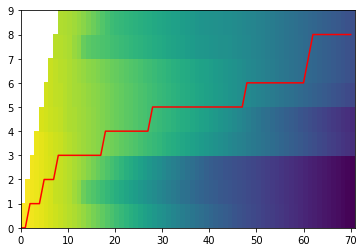

In [7]:
best_model = {}
acc_count = 0
for idx, dt in enumerate(data):  # Iterate over data samples
    maxloglik = None
    for digit in word_hmms.keys():  # Iterate over hmms
        obsloglik = log_multivariate_normal_density_diag(dt['lmfcc'], word_hmms[digit]['means'],
                                                         word_hmms[digit]['covars'])
        vloglik, vpath = viterbi(obsloglik, np.log(word_hmms[digit]['startprob']),
                                 np.log(word_hmms[digit]['transmat']))
        if maxloglik is None or maxloglik < vloglik:  # If better likelihood found
            best_model[idx] = digit  # Set most probable model
            maxloglik = vloglik  # Update max log likelihood
    if dt['digit'] == best_model[idx]:
        acc_count += 1
    # print("The best model for utterance " + str(idx) + " was hmm: " + str(best_model[idx]))
    # print("The real digit of utterance " + str(idx) + " was digit: " + str(dt['digit']) + "\n")
print("The accuracy of the predictions has been: " + str(np.round(acc_count / len(data) * 100, 2)) + "%")

logalpha = forward(example['obsloglik'], np.log(word_hmms['o']['startprob']), np.log(word_hmms['o']['transmat']))
vloglik, vpath = viterbi(example['obsloglik'], np.log(word_hmms['o']['startprob']),
                         np.log(word_hmms['o']['transmat']))
plt.pcolormesh(logalpha.T)
plt.plot(vpath.T, color="red")
plt.show()

Baum-Welch algorithm:

In [8]:
best_loglik = None
best_model = None
for digit in word_hmms.keys():  # Iterate over hmms
    print("Trying model " + str(digit))
    means = word_hmms[digit]['means']
    covars = word_hmms[digit]['covars']
    obsloglik = log_multivariate_normal_density_diag(data[10]['lmfcc'], means, covars)
    vloglik = 0
    newloglik = viterbi(obsloglik, np.log(word_hmms[digit]['startprob']),
                        np.log(word_hmms[digit]['transmat']))[0]
    it = 0
    while it < 20 and abs(newloglik - vloglik) > 1.0:
        vloglik = newloglik  # Update value of log-likelihood
        forward_prob = forward(obsloglik, np.log(word_hmms[digit]['startprob']),
                               np.log(word_hmms[digit]['transmat']))
        backward_prob = backward(obsloglik, np.log(word_hmms[digit]['transmat']))
        log_gamma = statePosteriors(forward_prob, backward_prob)
        means, covars = updateMeanAndVar(data[10]['lmfcc'], log_gamma)
        obsloglik = log_multivariate_normal_density_diag(data[10]['lmfcc'], means, covars)
        newloglik = viterbi(obsloglik, np.log(word_hmms[digit]['startprob']),
                            np.log(word_hmms[digit]['transmat']))[0]
        it += 1  # Update number of iterations
    print("Log-likelihood: " + str(newloglik) + ". Number of iterations until convergence: " + str(it))
    if best_loglik is None or newloglik > best_loglik:
        best_loglik = newloglik
        best_model = digit
print("The best log-likelihood is: " + str(best_loglik) + ". It corresponds to the model " + str(best_model))

Trying model o
Log-likelihood: -6318.836143374649. Number of iterations until convergence: 5
Trying model z
Log-likelihood: -5833.2706240493735. Number of iterations until convergence: 5
Trying model 1
Log-likelihood: -5903.338261970016. Number of iterations until convergence: 10
Trying model 2
Log-likelihood: -6190.713363055122. Number of iterations until convergence: 5
Trying model 3
Log-likelihood: -6012.101687040113. Number of iterations until convergence: 4
Trying model 4
Log-likelihood: -5994.050816900842. Number of iterations until convergence: 5
Trying model 5
Log-likelihood: -5963.922425732666. Number of iterations until convergence: 5
Trying model 6
Log-likelihood: -5884.528943767897. Number of iterations until convergence: 5
Trying model 7
Log-likelihood: -5682.161964496241. Number of iterations until convergence: 5
Trying model 8
Log-likelihood: -6185.97163186002. Number of iterations until convergence: 4
Trying model 9
Log-likelihood: -5953.968391594907. Number of iteratio